In [1]:
import cloudvolume
import pandas as pd
from imageryclient import ImageryClient
import matplotlib.pyplot as plt
import numpy as np

In [3]:
syn_df = pd.read_csv('data/soma_subgraph_synapses_spines_v185.csv')

In [4]:
img_source = "precomputed://https://storage.googleapis.com/microns_public_datasets/pinky100_v0/son_of_alignment_v15_rechunked"
seg_source = "precomputed://https://storage.googleapis.com/microns_public_datasets/pinky100_v185/seg"

you can use cloudvolume to download data from these as if they were giant numpy arrays


In [5]:
img_cv = cloudvolume.CloudVolume(img_source, use_https=True)

In [6]:
img_cv.bounds

Bbox([35000, 31000, 1],[125000, 84500, 2177], dtype=int32)

In [7]:
img = img_cv[70000:70000+500, 70000:70000+500, 1025:1026]

Downloading: 100%|██████████| 9/9 [00:00<00:00,  9.83it/s]


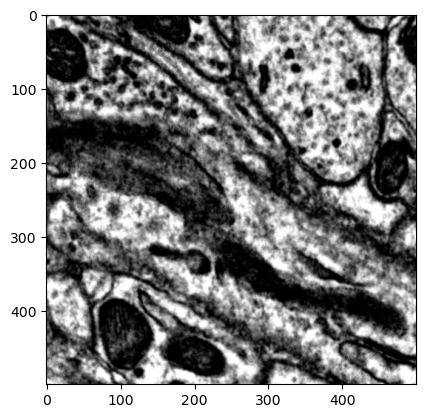

In [8]:
plt.imshow(np.squeeze(img), cmap=plt.cm.gray)

In [9]:
import fastremap

you can also download segmentation images the same way


In [10]:
seg_cv = cloudvolume.CloudVolume(seg_source)
seg_cv.bounds

Bbox([17920, 14848, 0],[61440, 40960, 2176], dtype=int32)

In [11]:
seg = seg_cv[35000:35000+250, 35000:35000+250, 1025]

Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


now because each pixel contains the ID of the object
visualizing this as a normal image doesn't make sense
fastremap can help you map these large IDs to smaller ones
so visualization makes more sense as an image

In [12]:
# may be much faster than np.unique
uniq, cts = fastremap.unique(seg, return_counts=True) 
# relabel values from 1 and refit data type
seg, remapping = fastremap.renumber(seg, in_place=True)

remapping contains how these IDs were mapped

In [13]:
remapping

{648518346349539900: 3,
 648518346349538001: 18,
 648518346341397520: 6,
 648518346349489855: 2,
 648518346342162893: 5,
 648518346342099875: 12,
 648518346342159814: 14,
 648518346341393364: 16,
 648518346349539590: 4,
 648518346349493031: 1,
 648518346342161983: 17,
 0: 0,
 648518346349508722: 15,
 648518346341363379: 9,
 648518346341369428: 10,
 648518346341390506: 8,
 648518346342167007: 7,
 648518346342161920: 11,
 648518346349537989: 13}

this is the list of IDs contained in this cutout

In [14]:
uniq

array([                 0, 648518346349493031, 648518346349489855,
       648518346349539900, 648518346349539590, 648518346342162893,
       648518346341397520, 648518346342167007, 648518346341390506,
       648518346341363379, 648518346341369428, 648518346342161920,
       648518346342099875, 648518346349537989, 648518346342159814,
       648518346349508722, 648518346341393364, 648518346342161983,
       648518346349538001], dtype=uint64)

now we can visualize the remapped IDs like an image

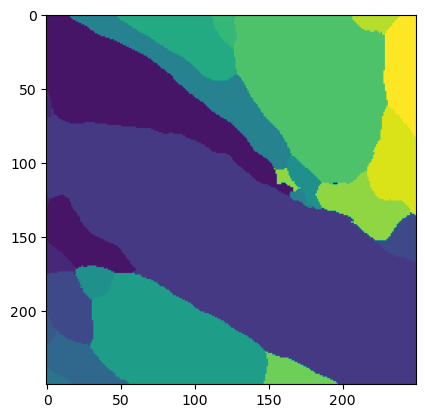

In [15]:
plt.imshow(np.squeeze(seg))

note the segmentation full resolution is at half the resolution
of the imagery so there isn't a 1-1 correspondance between pixels

In [16]:
seg.shape, img.shape

((250, 250, 1, 1), (500, 500, 1, 1))

the ImageryClient from AnnotationFrameworkClient can help you think less
about how to manage bounds between segmentation and images layers
when you are trying to make cutouts

In [17]:
ic=ImageryClient(image_source = img_source,
                 segmentation_source=seg_source)

lets visualize the image and segmentation in the area
that surrounds a random synapse

In [18]:
syn_num = 400
post_id =syn_df.loc[syn_num,'post_root_id']
pre_id = syn_df.loc[syn_num,'pre_root_id']
syn=syn_df.loc[syn_num]

this will pick out bounds with a 300 pixel (3.58*300 = 1027 nm) x,y region
and 5 sections @40 nm in z. Note that because of how slices work, for example, a lower bound of z and an upper bound of z+3 only returns the sections at z, z+1, and z+2 but is not inclusive of z+3.

In [19]:
bounds=[[syn.ctr_pos_x_vx-150, syn.ctr_pos_y_vx-150, syn.ctr_pos_z_vx-2],
        [syn.ctr_pos_x_vx+150, syn.ctr_pos_y_vx+150, syn.ctr_pos_z_vx+3]]


this downloads the imagery as a numpy array and segmentation as a dictionary of arrays


In [20]:
imgvol, segdict = ic.image_and_segmentation_cutout(bounds,
                                                   split_segmentations=True)

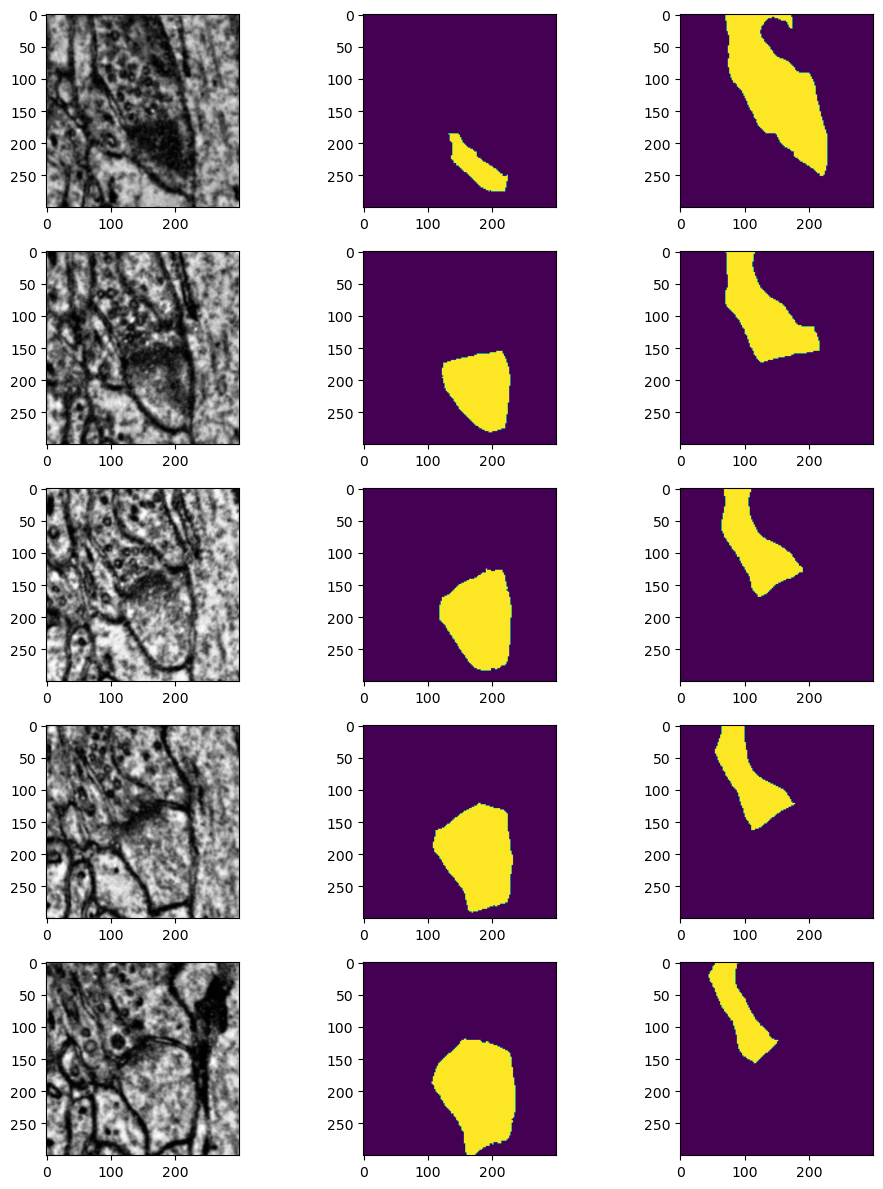

In [21]:
f ,ax = plt.subplots(5,3, figsize=(10,12))
# lets loop over z sections
for i in range(5):
    # plot the images in column 0
    ax[i, 0].imshow(np.squeeze(imgvol[:,:,i]),
                    cmap=plt.cm.gray,
                    vmax=255,
                    vmin=0)
    # plot the pre-synaptic mask in column 1
    ax[i, 1].imshow(np.squeeze(segdict[post_id][:,:,i]))
    # plot the post-synaptic mask in column 2
    ax[i, 2].imshow(np.squeeze(segdict[pre_id][:,:,i]))
f.tight_layout()

this function will save a series of PNG images that are exactly the same size
so you can easily combine them as layers in Illustrator or photoshop
to make a publication quality figures

In [22]:
ic.save_image_and_segmentation_masks('synapse_test', bounds=bounds,
                                     root_ids = [pre_id, post_id],
                                     segmentation_colormap={pre_id:[255, 0,0,255], 
                                                            post_id:[0, 255, 0 ,255]})

TypeError: imageryclient.imagery.save_image_slices() argument after ** must be a mapping, not tuple

![alt text](img/synapse_figure.png "Synapse Figure")
Here's an example image that used this output to make a figure highlighting the pre and post
synaptic regions around this synapse 